In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('Train.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
df.shape

(8523, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [5]:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [6]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [7]:
df.duplicated().any()

np.False_

# EXPLORATORY DATA ANALYSIS

In [8]:
cont_features = df[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']]
cont_features.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,9.30,0.016047,249.8092,1999,3735.1380
1,5.92,0.019278,48.2692,2009,443.4228
2,17.50,0.016760,141.6180,1999,2097.2700
3,19.20,0.000000,182.0950,1998,732.3800
4,8.93,0.000000,53.8614,1987,994.7052


In [9]:
for col in cont_features.columns:
    print(f"Column {col} has {df[col].nunique()} unique values")

Column Item_Weight has 415 unique values
Column Item_Visibility has 7880 unique values
Column Item_MRP has 5938 unique values
Column Outlet_Establishment_Year has 9 unique values
Column Item_Outlet_Sales has 3493 unique values


In [10]:
cont_features.corr()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.014048,0.027141,-0.011588,0.014123
Item_Visibility,-0.014048,1.000000,-0.001315,-0.074834,-0.128625
Item_MRP,0.027141,-0.001315,1.000000,0.005020,0.567574
Outlet_Establishment_Year,-0.011588,-0.074834,0.005020,1.000000,-0.049135
Item_Outlet_Sales,0.014123,-0.128625,0.567574,-0.049135,1.000000


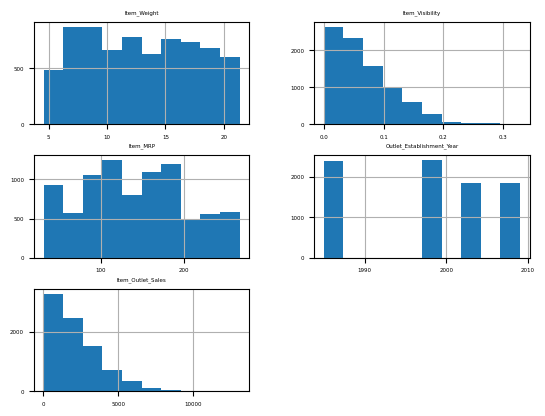

In [11]:
fig = cont_features.hist(xlabelsize=4, ylabelsize=4)
[x.title.set_size(4) for x in fig.ravel()]
plt.show()

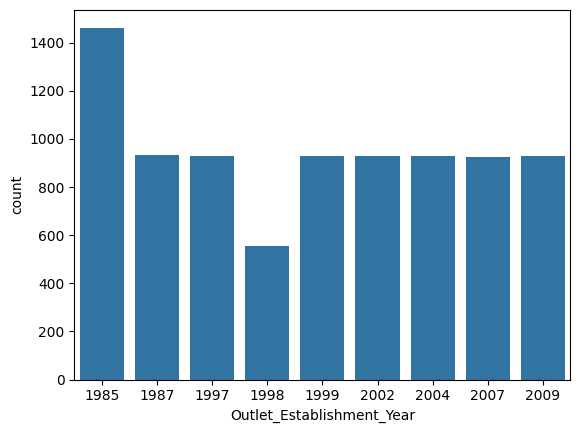

In [12]:
sns.countplot(x='Outlet_Establishment_Year', data=df)
plt.show()

In [13]:
df['Item_Weight'] = df['Item_Weight'].fillna(df['Item_Weight'].mean())

In [14]:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [15]:
cat_features = df.drop(columns=cont_features, axis=1)
cat_features.head()

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDA15,Low Fat,Dairy,OUT049,Medium,Tier 1,Supermarket Type1
1,DRC01,Regular,Soft Drinks,OUT018,Medium,Tier 3,Supermarket Type2
2,FDN15,Low Fat,Meat,OUT049,Medium,Tier 1,Supermarket Type1
3,FDX07,Regular,Fruits and Vegetables,OUT010,NaN,Tier 3,Grocery Store
4,NCD19,Low Fat,Household,OUT013,High,Tier 3,Supermarket Type1


In [16]:
for col in cat_features.columns:
    print(f"Column {col} has {df[col].nunique()} unique values")

Column Item_Identifier has 1559 unique values
Column Item_Fat_Content has 5 unique values
Column Item_Type has 16 unique values
Column Outlet_Identifier has 10 unique values
Column Outlet_Size has 3 unique values
Column Outlet_Location_Type has 3 unique values
Column Outlet_Type has 4 unique values


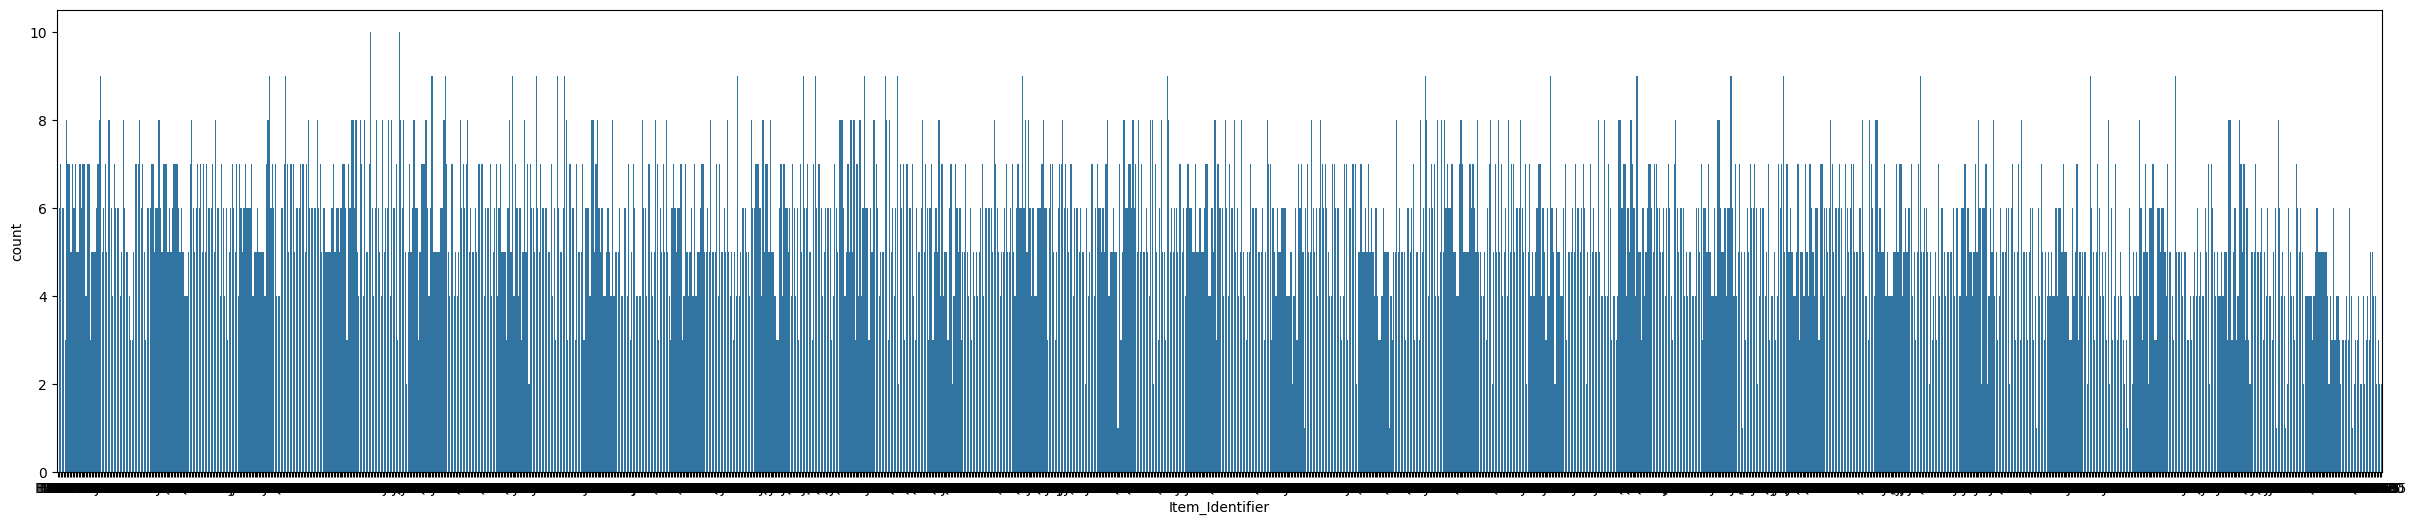

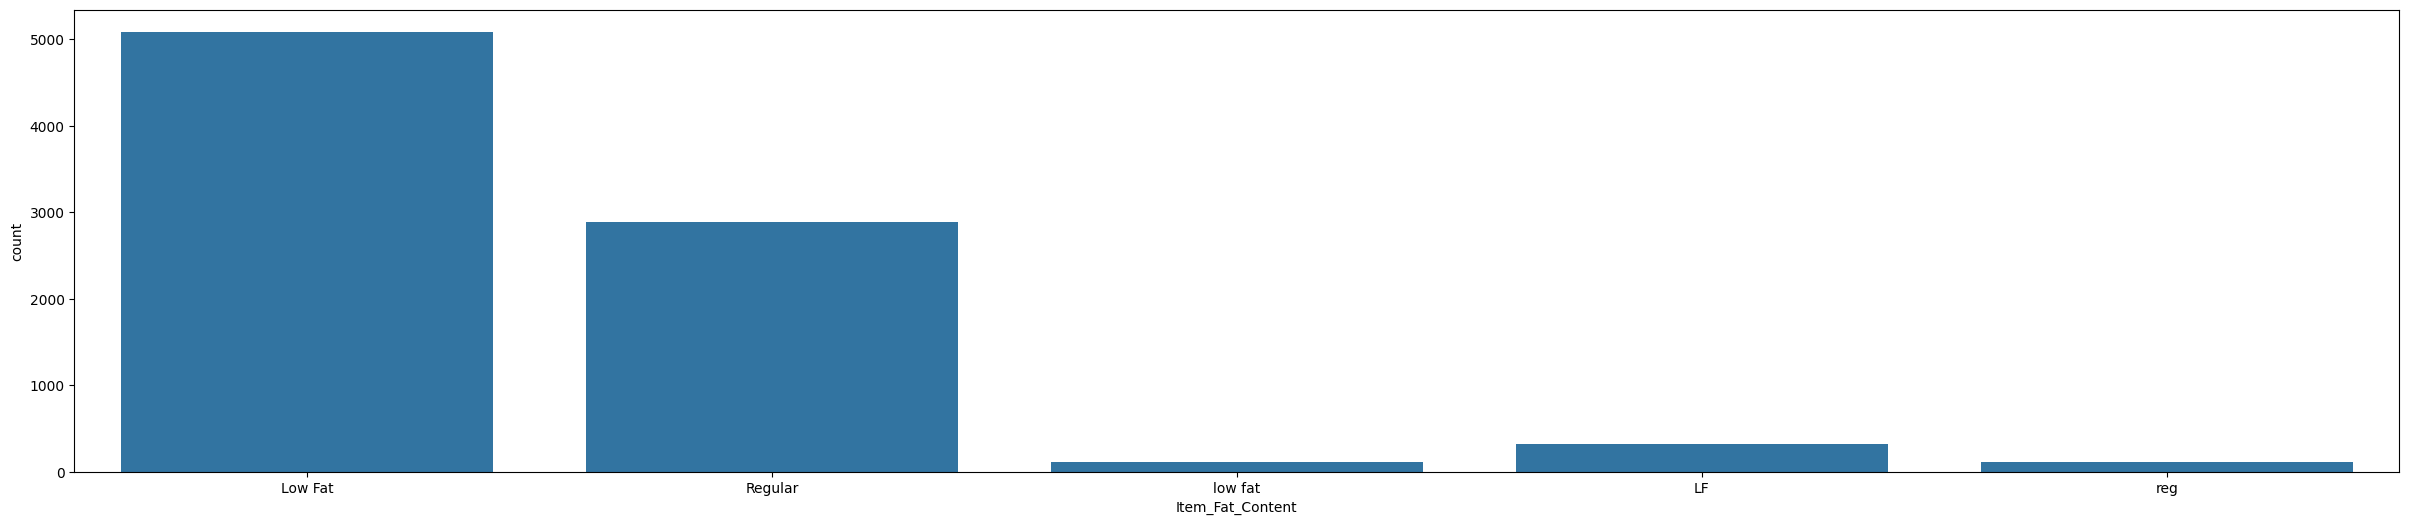

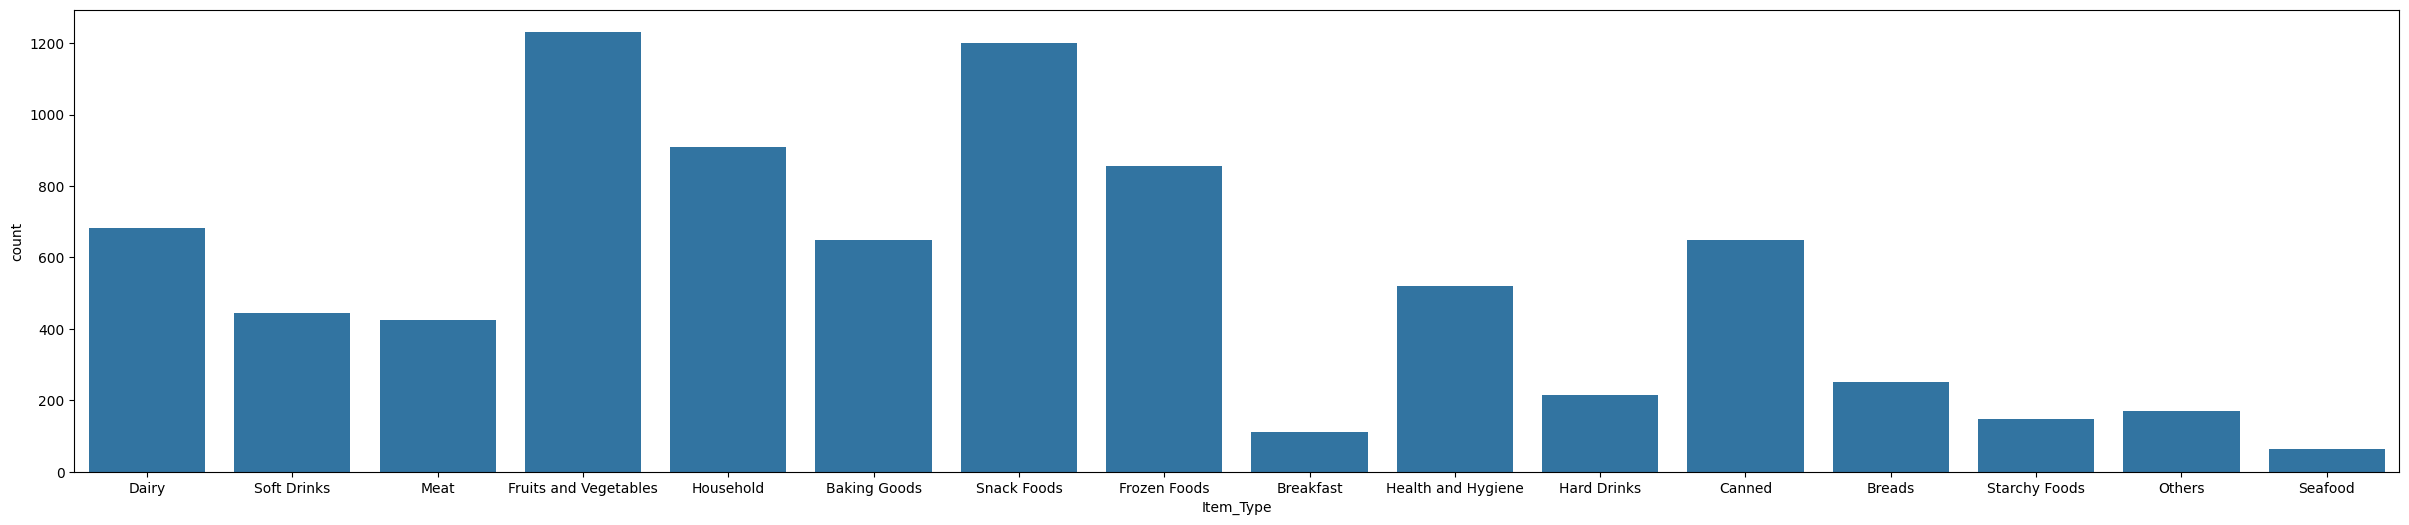

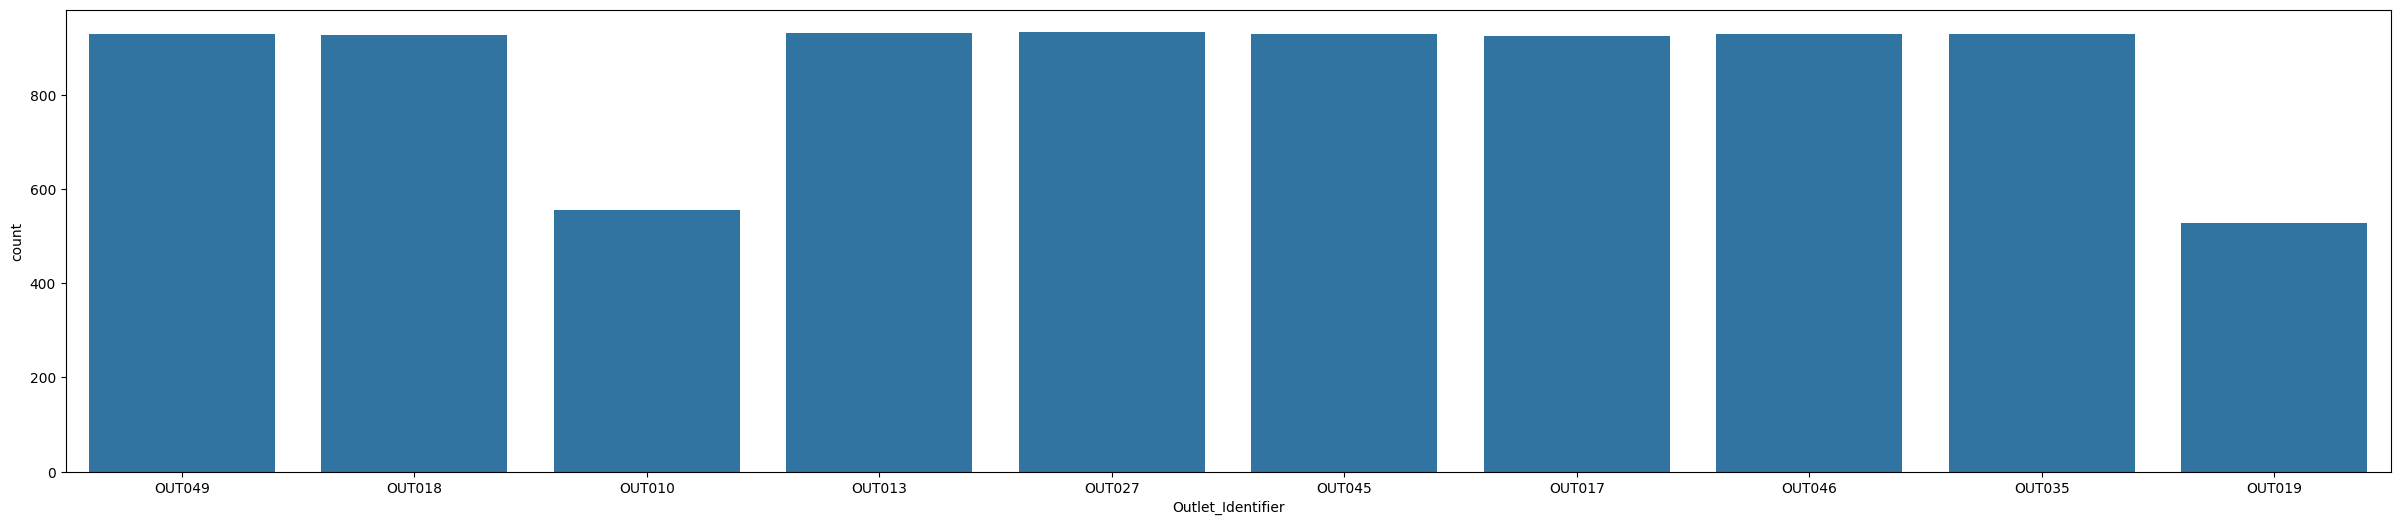

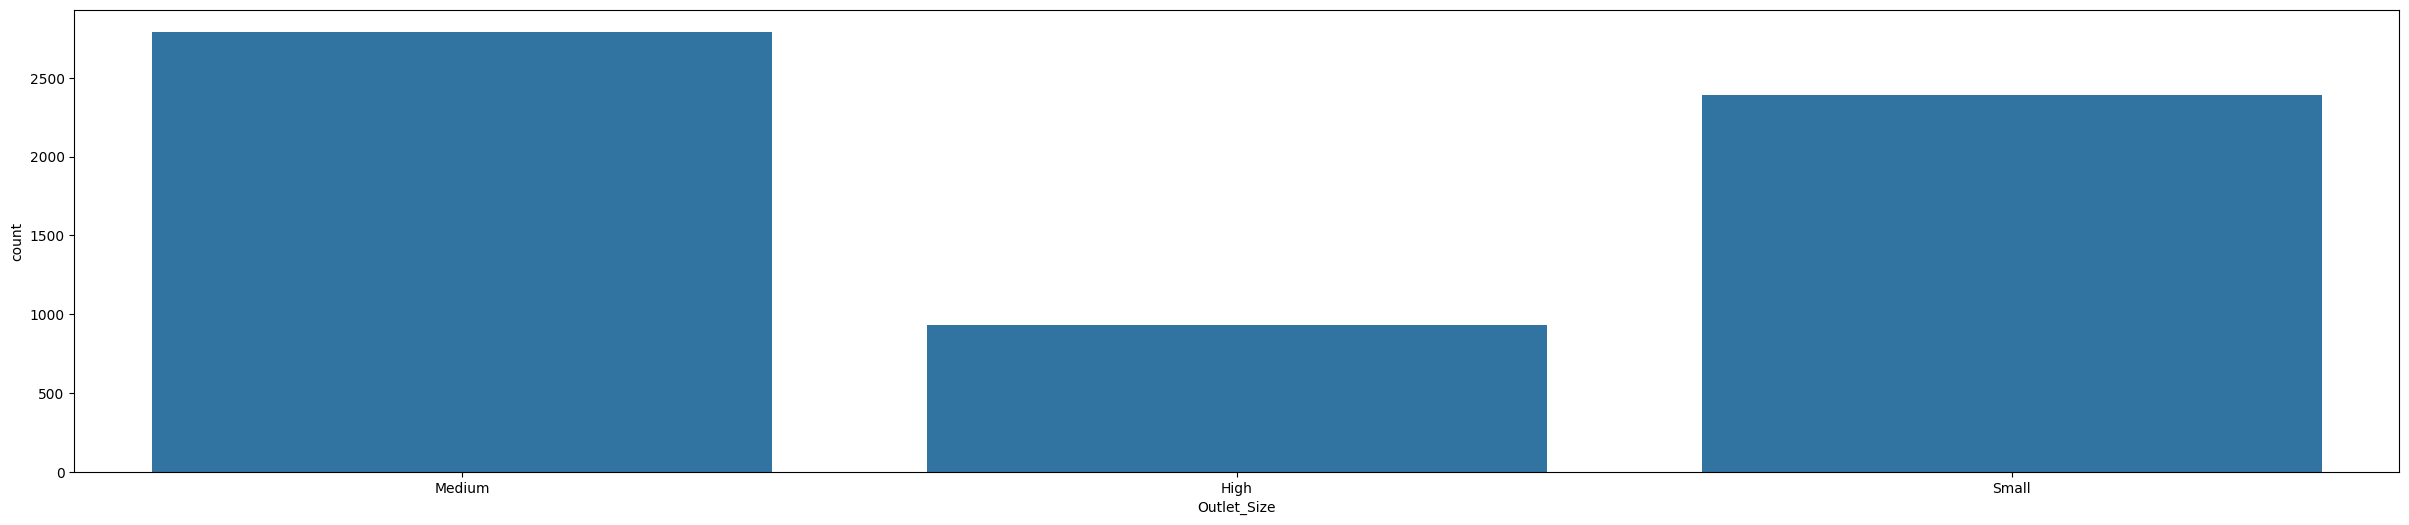

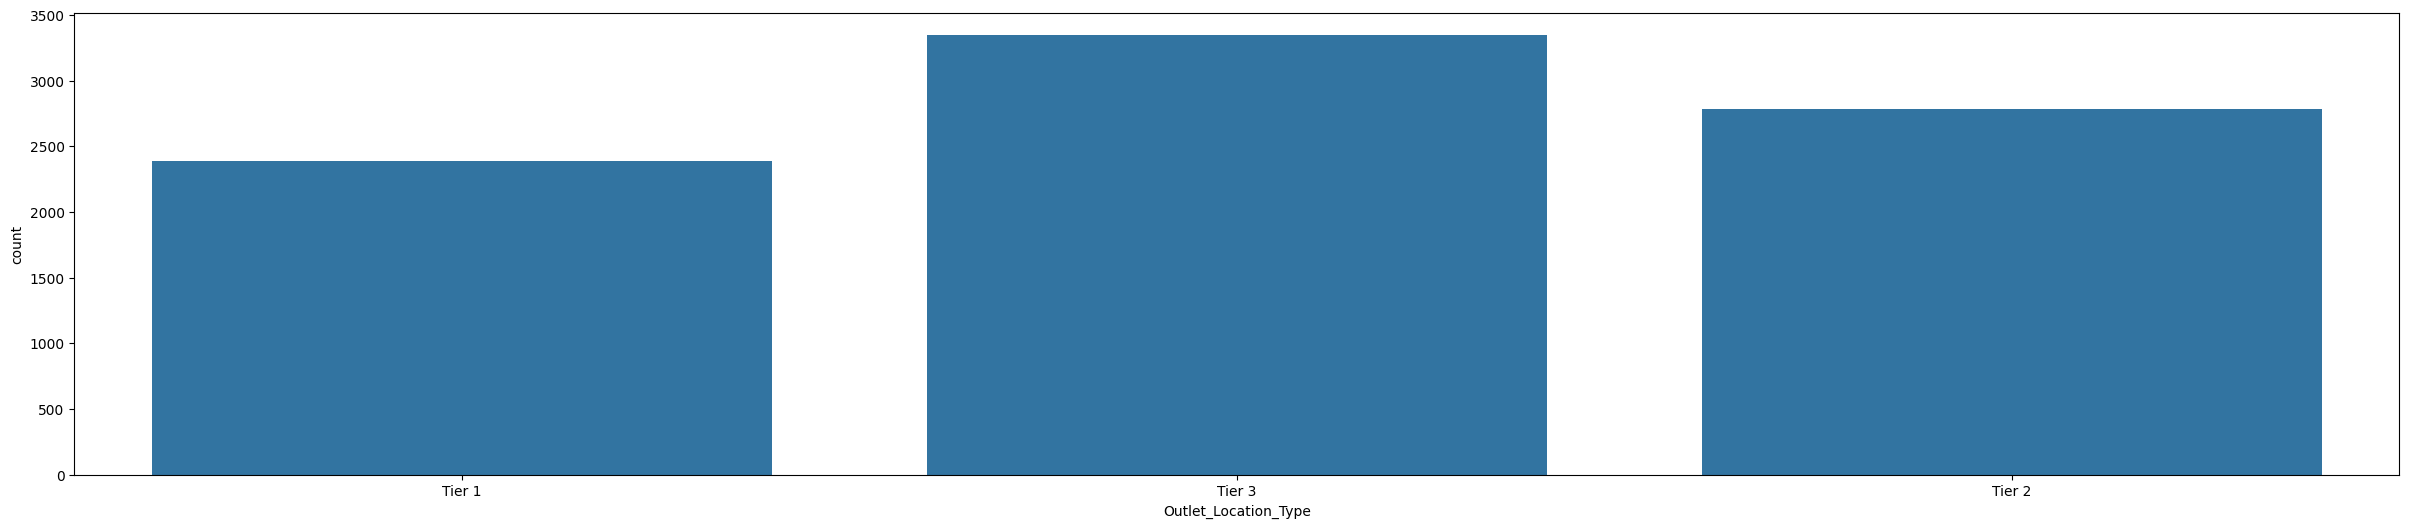

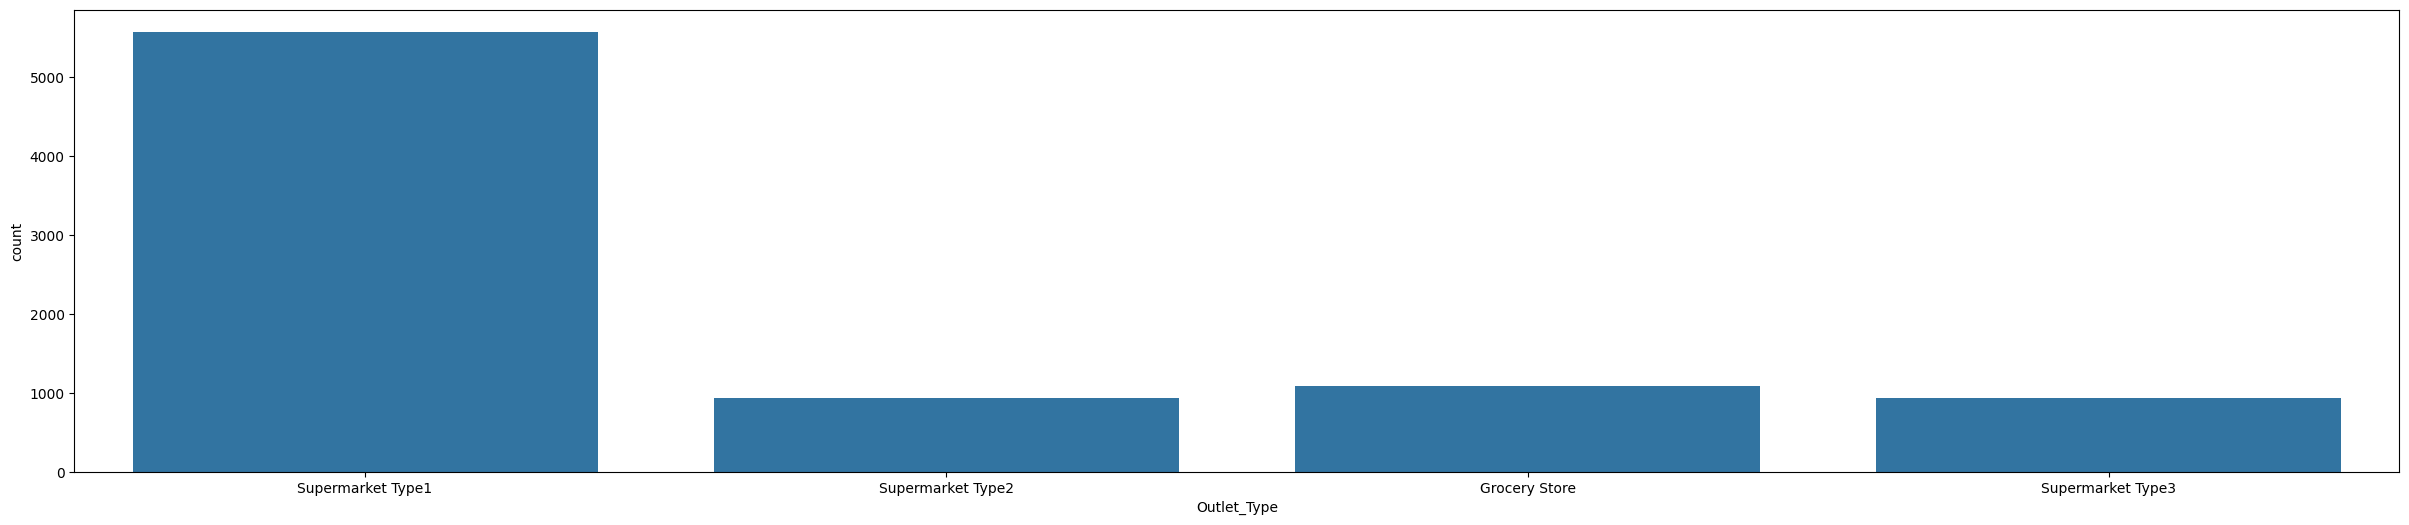

In [17]:
for feature in cat_features:
    plt.figure(figsize=(30,6))
    sns.countplot(x=feature, data=cat_features)
    plt.show()

# DATA CLEANING

In [18]:
# Join values that belong to the same category
df = df.replace({'Item_Fat_Content': {'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'}})
df['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

In [19]:
# Find the mode of Outlet_Size given the Outlet_Type
mode = df.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))
print(mode)

Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


In [20]:
# Check the Outlet_Type where there is a nan value in Outlet_Size and replace it with the mode value
nan = df['Outlet_Size'].isnull()
df.loc[nan, 'Outlet_Size'] = df.loc[nan, 'Outlet_Type'].apply(lambda x: mode[x])
df.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [21]:
df['Outlet_Size'].value_counts()

Outlet_Size
Small     4798
Medium    2793
High       932
Name: count, dtype: int64

In [22]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [23]:
# Check for outliers
def detect_outliers(feature):
    outliers = []
    data = df[feature]
    mean = np.mean(data)
    std = np.std(data)
    
    for x in data:
        z = (x-mean)/std
        if np.abs(z) > 3:
            outliers.append(x)
            
    print(f"\nOutliers for {feature}")
    print(f"--95p: {round(data.quantile(0.95),4)}, Values above 95p: {len([i for i in data if i>data.quantile(0.95)])}")
    print(f"--3std: {round(mean+3*std)}, Values above 3std: {len(outliers)}")
    print(f"--99p: {round(data.quantile(0.99),4)}, Values above 99p: {len([i for i in data if i>data.quantile(0.99)])}")

In [24]:
for feature in ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']:
    detect_outliers(feature)


Outliers for Item_Weight
--95p: 20.19, Values above 95p: 427
--3std: 26, Values above 3std: 0
--99p: 20.85, Values above 99p: 59

Outliers for Item_Visibility
--95p: 0.1638, Values above 95p: 427
--3std: 0, Values above 3std: 95
--99p: 0.2262, Values above 99p: 86

Outliers for Item_MRP
--95p: 250.7692, Values above 95p: 427
--3std: 328, Values above 3std: 0
--99p: 263.0226, Values above 99p: 85

Outliers for Outlet_Establishment_Year
--95p: 2009.0, Values above 95p: 0
--3std: 2023, Values above 3std: 0
--99p: 2009.0, Values above 99p: 0

Outliers for Item_Outlet_Sales
--95p: 5522.811, Values above 95p: 424
--3std: 7300, Values above 3std: 90
--99p: 7366.0117, Values above 99p: 86


In [25]:
# Remove outliers
df['Item_Weight']= df['Item_Weight'].clip(upper=df['Item_Weight'].quantile(0.99))
df['Item_Visibility']= df['Item_Visibility'].clip(upper=df['Item_Visibility'].quantile(0.99))
df['Item_MRP']= df['Item_MRP'].clip(upper=df['Item_MRP'].quantile(0.99))
df['Item_Outlet_Sales']= df['Item_Outlet_Sales'].clip(upper=df['Item_Outlet_Sales'].quantile(0.99))

In [26]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.855299,0.065712,140.978365,1997.831867,2169.737084
std,4.221580,0.050023,62.246553,8.371760,1663.362800
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,20.850000,0.226249,263.022600,2009.000000,7366.011720


# TRANSFORMING THE DATA

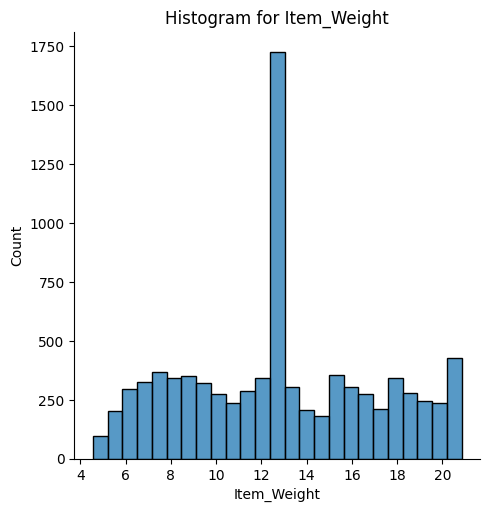

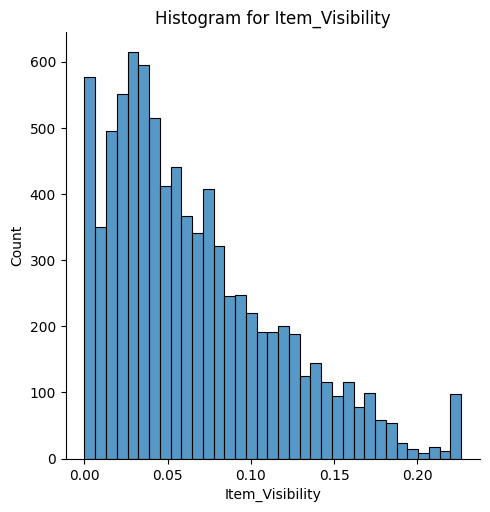

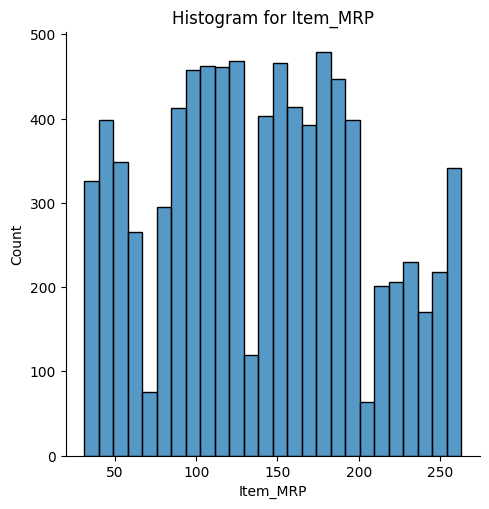

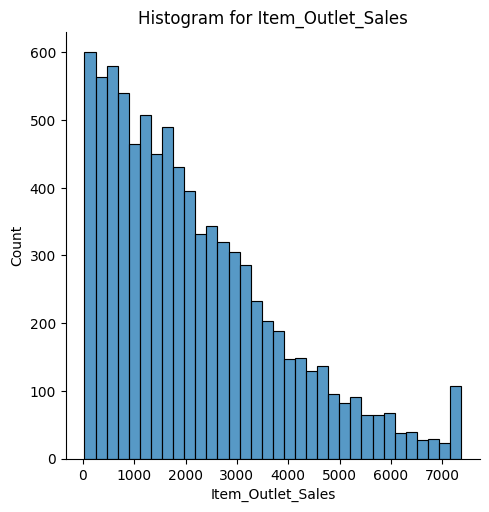

In [28]:
for feature in ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']:
    sns.displot(df[feature], kde=False)
    plt.title(f"Histogram for {feature}")
    plt.show()

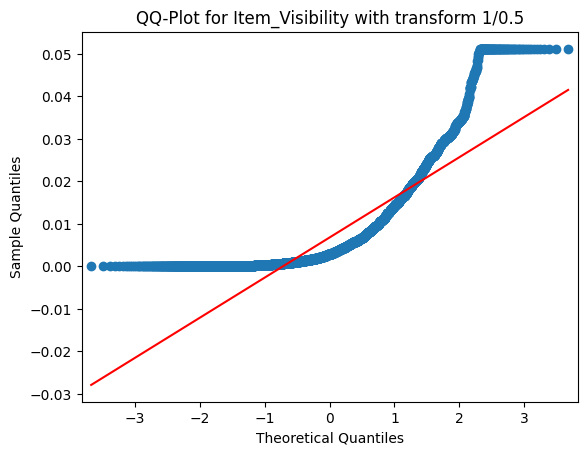

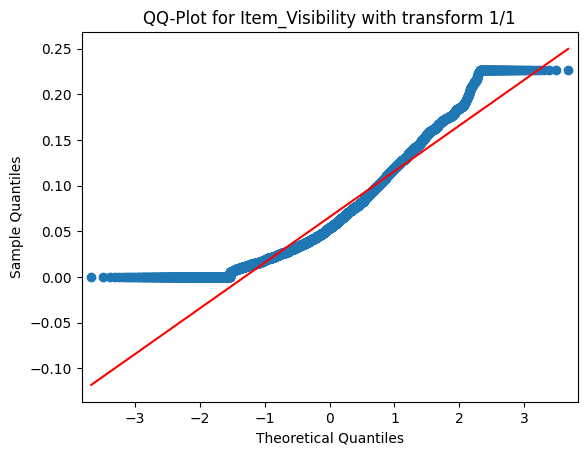

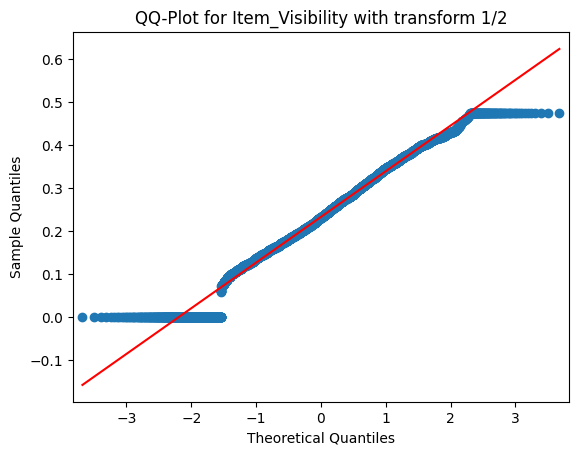

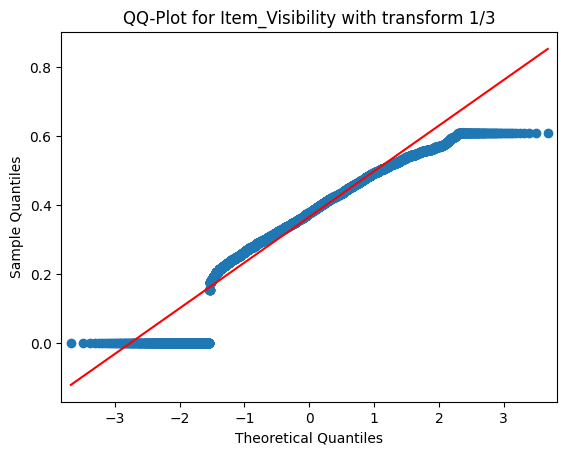

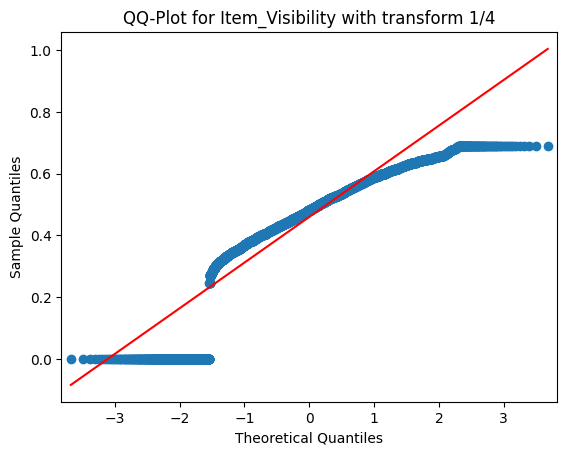

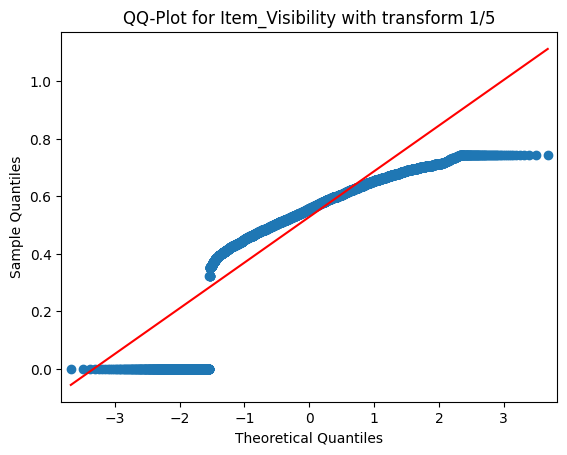

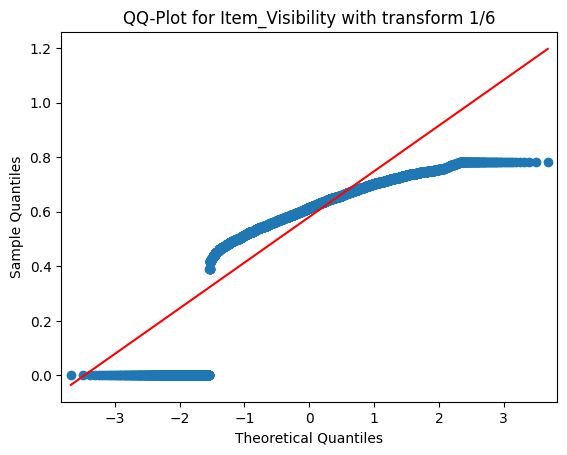

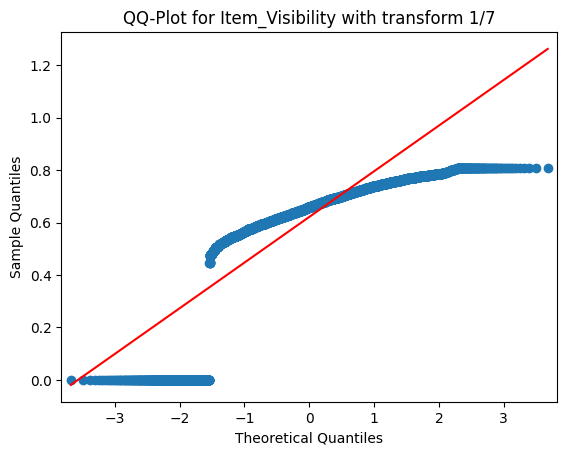

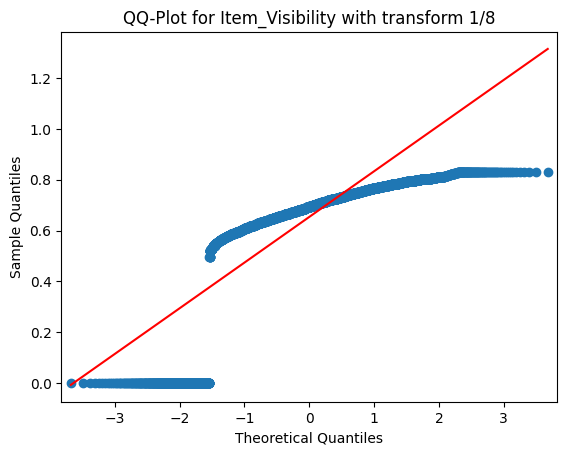

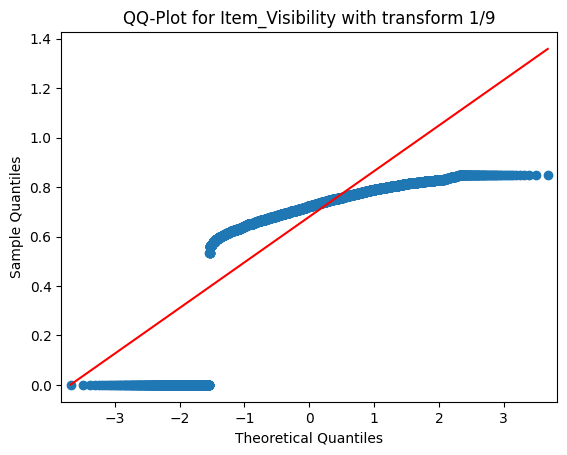

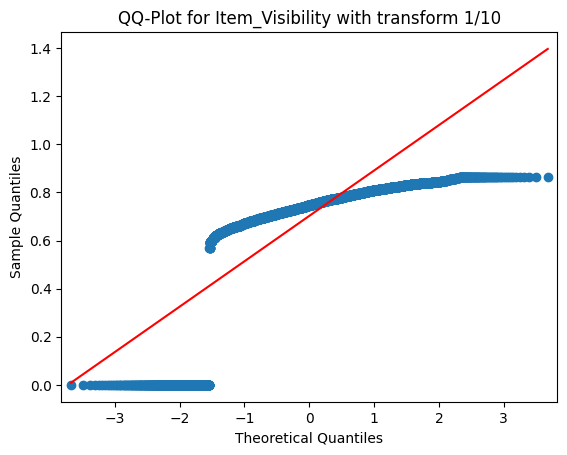

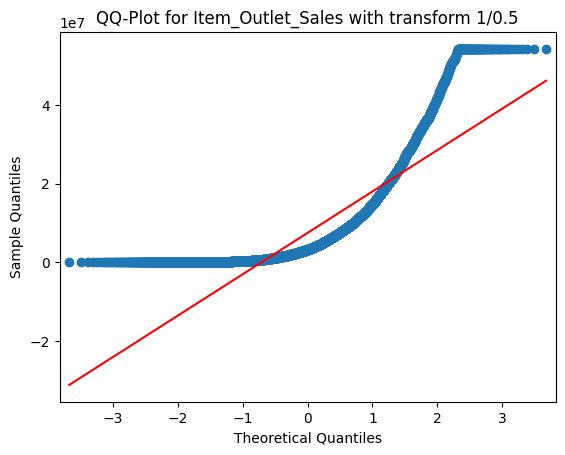

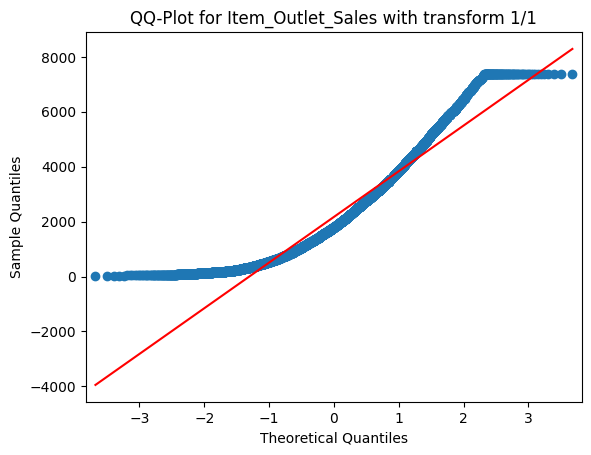

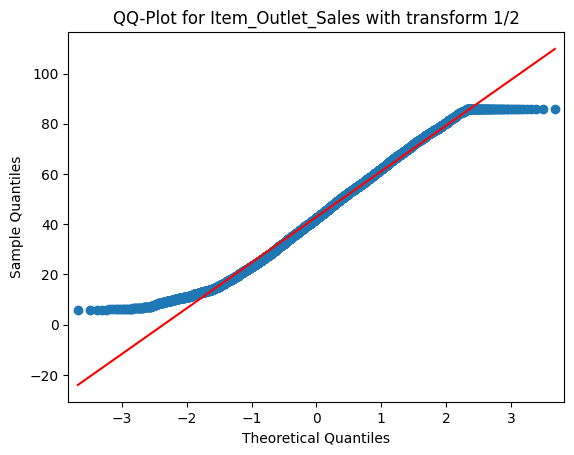

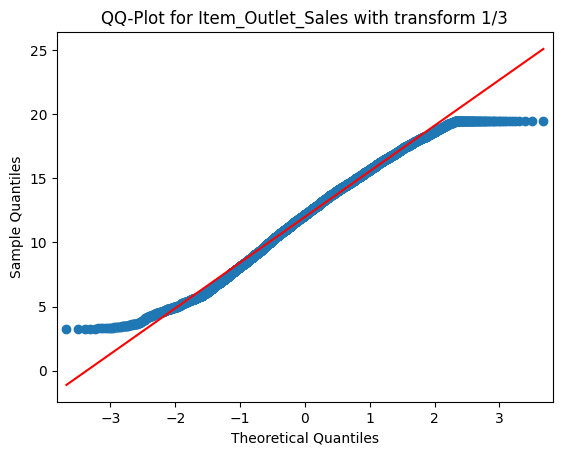

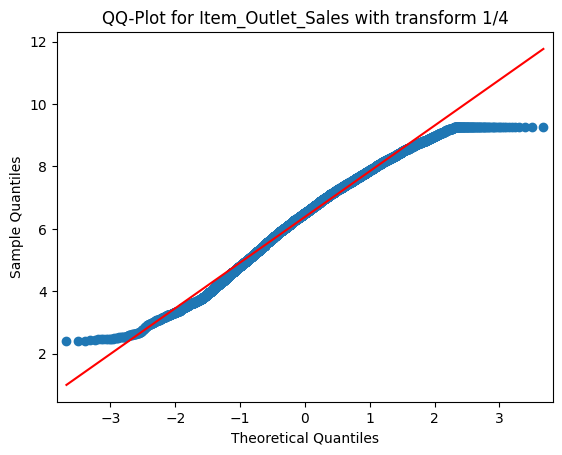

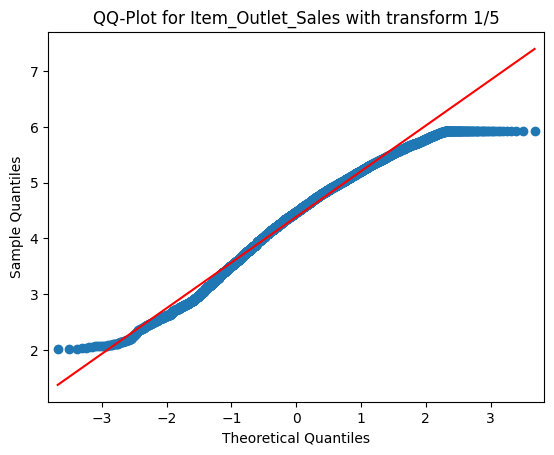

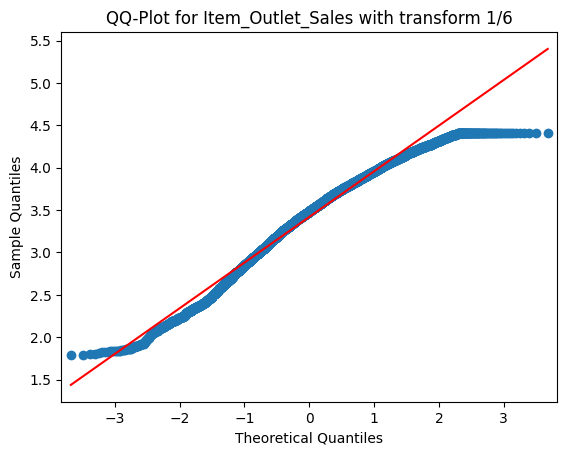

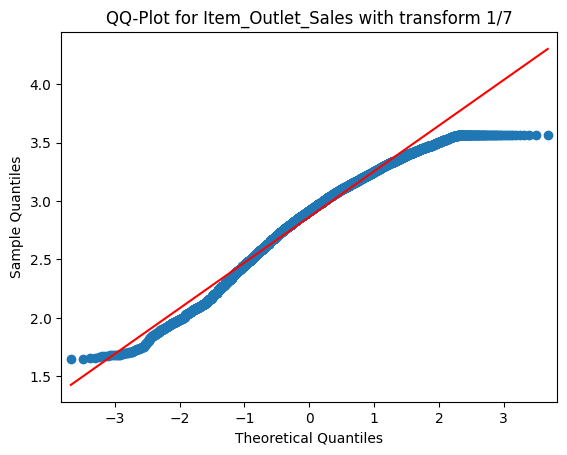

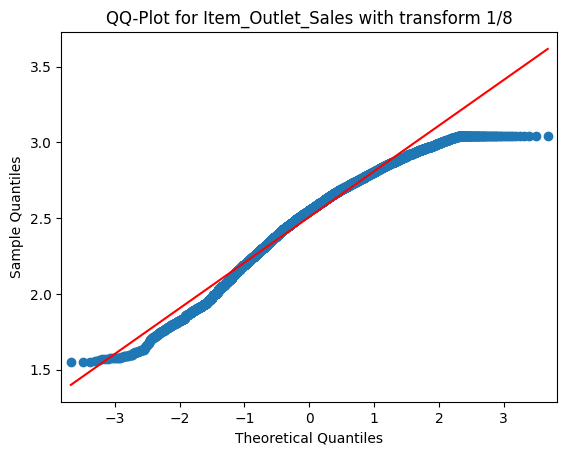

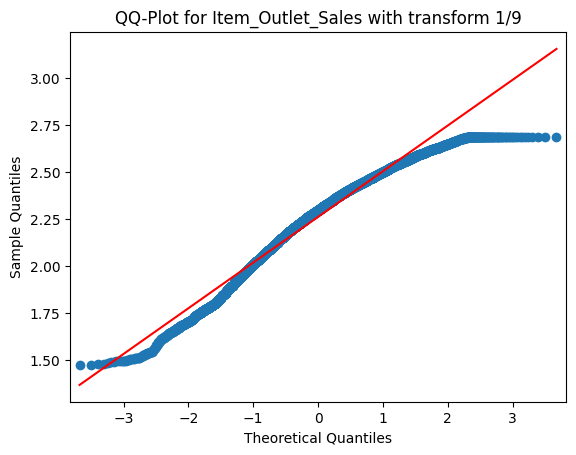

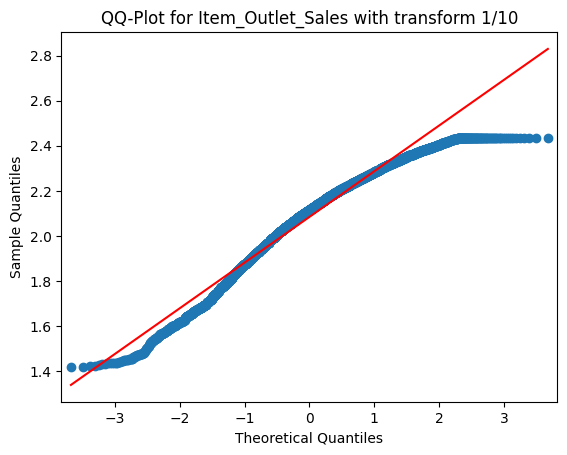

In [29]:
for feature in ['Item_Visibility', 'Item_Outlet_Sales']:
    for i in [0.5,1,2,3,4,5,6,7,8,9,10]:
        data = df[feature]**(1/i)
        qqplot(data, line='s')
        plt.title(f"QQ-Plot for {feature} with transform 1/{str(i)}")
        plt.show()

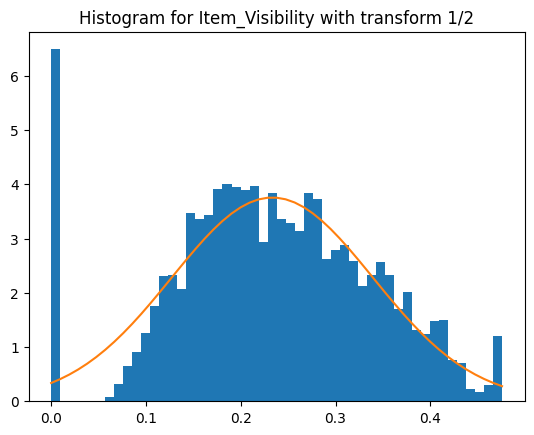

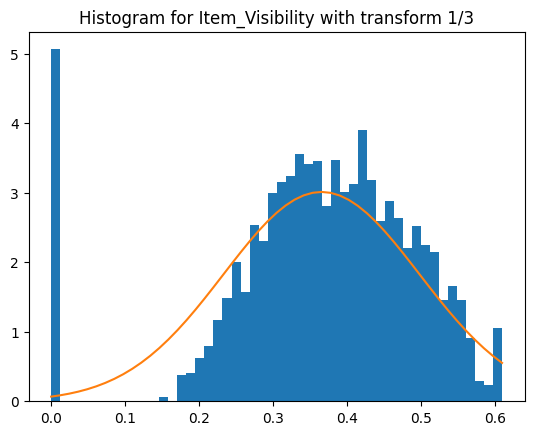

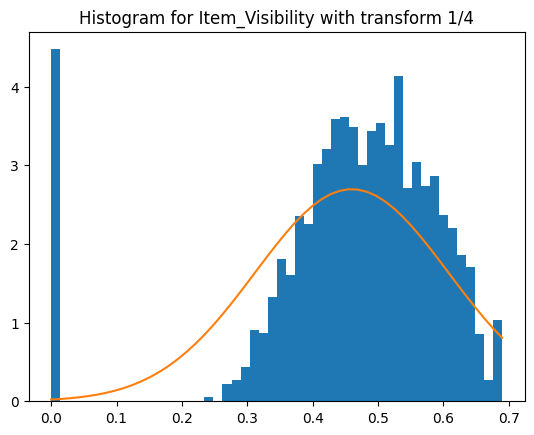

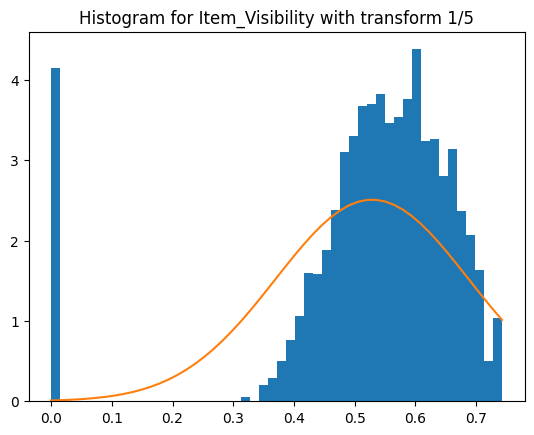

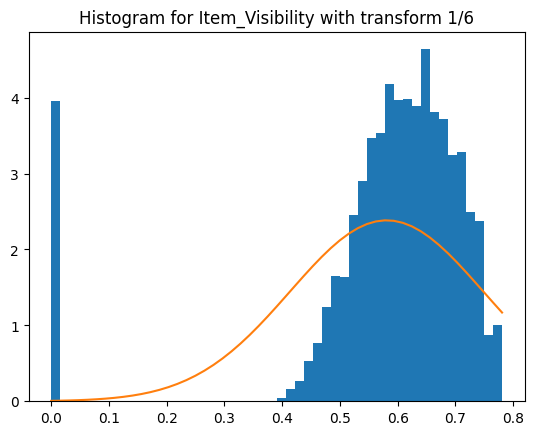

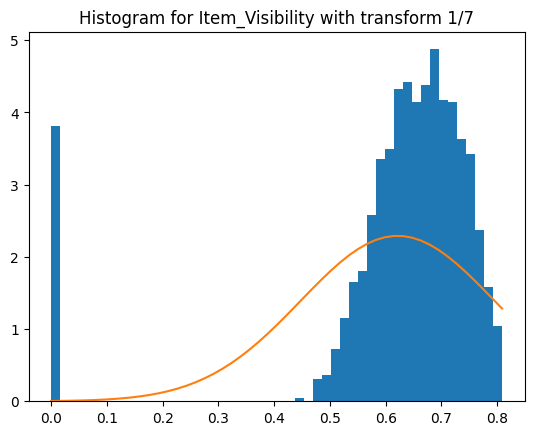

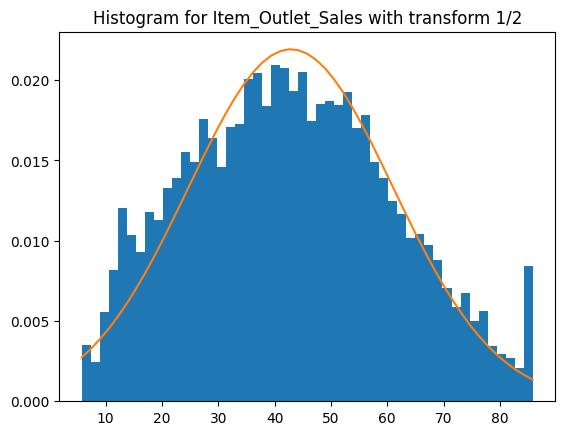

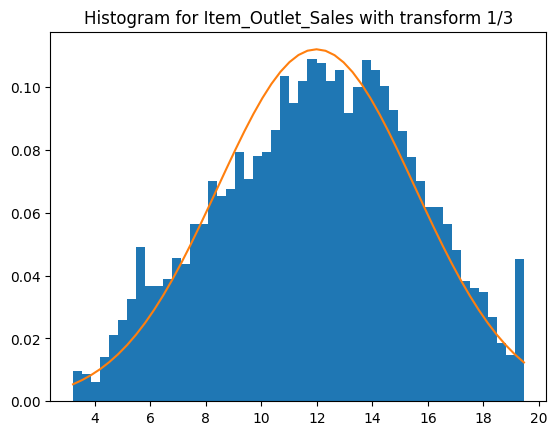

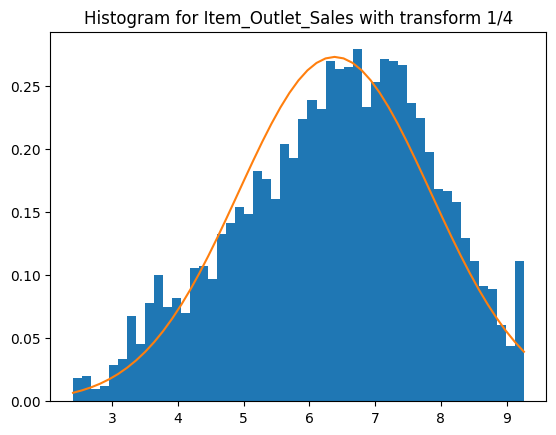

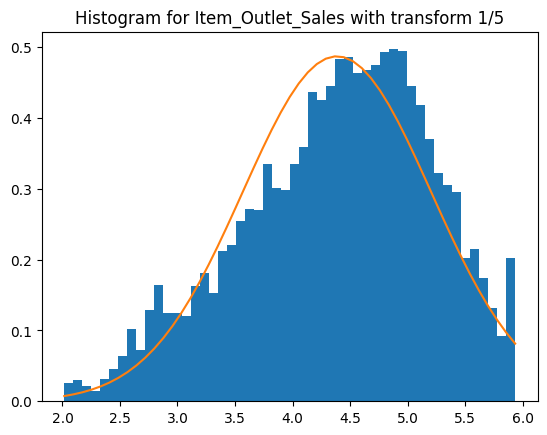

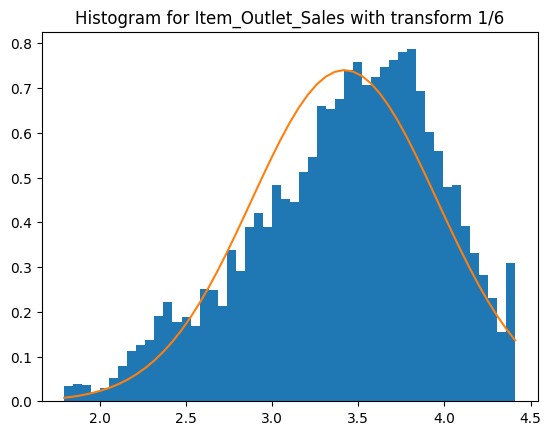

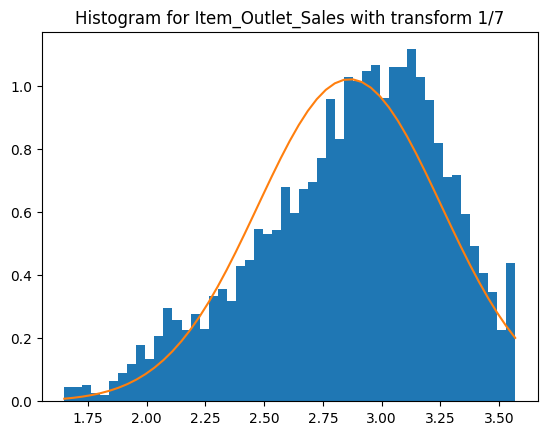

In [32]:
for feature in ['Item_Visibility', 'Item_Outlet_Sales']:
    for i in [2,3,4,5,6,7]:
        data = df[feature]**(1/i)
        n, bins, patches = plt.hist(data, 50, density=True)
        mean = np.mean(data)
        std = np.std(data)
        plt.plot(bins, stats.norm.pdf(bins, mean, std))
        plt.title(f"Histogram for {feature} with transform 1/{str(i)}")
        plt.show()

In [33]:
df['Item_Visibility_transformed'] = df['Item_Visibility'].apply(lambda x: x**(1/2))
df['Item_Outlet_Sales_transformed'] = df['Item_Outlet_Sales'].apply(lambda x: x**(1/2))
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Visibility_transformed,Item_Outlet_Sales_transformed
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,0.126678,61.115775
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,0.138846,21.057607
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,0.129461,45.795961
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,0.000000,27.062520
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,0.000000,31.538947


# CONVERT CATEGORICAL FEATURES TO NUMERICAL

In [34]:
for feature in ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type','Outlet_Type']:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Visibility_transformed,Item_Outlet_Sales_transformed
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380,0.126678,61.115775
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228,0.138846,21.057607
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700,0.129461,45.795961
3,1121,19.20,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800,0.000000,27.062520
4,1297,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052,0.000000,31.538947


In [36]:
# Create different datasets
original_features = ['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year',
                    'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales']


selected_features = ['Item_Weight', 'Item_Fat_Content', 'Item_Visibility_transformed', 'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year',
                    'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales_transformed']

In [43]:
X_original = df[original_features].drop(columns='Item_Outlet_Sales', axis=1)
y_original = df[original_features]['Item_Outlet_Sales']
print(X_original.shape)
print(y_original.shape)

(8523, 10)
(8523,)


In [45]:
X_selected = df[selected_features].drop(columns='Item_Outlet_Sales_transformed', axis=1)
y_selected = df[selected_features]['Item_Outlet_Sales_transformed']
print(X_selected.shape)
print(y_selected.shape)

(8523, 10)
(8523,)


<Axes: >

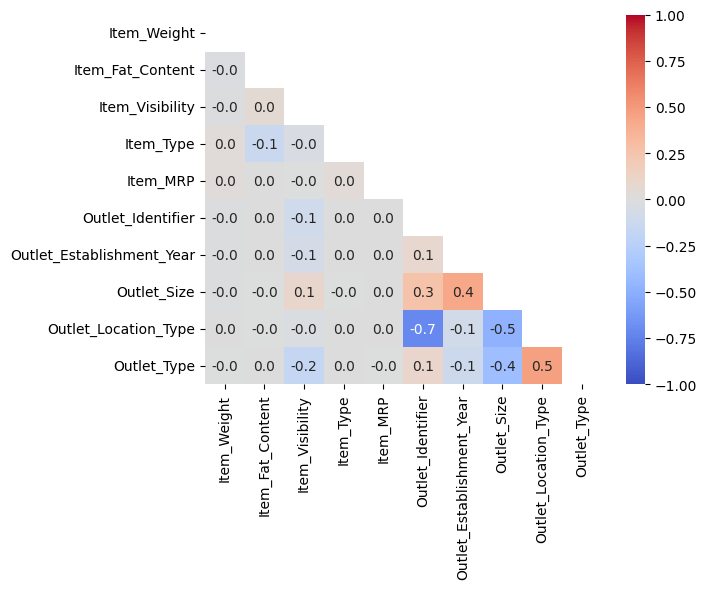

In [44]:
matrix_original = np.triu(X_original.corr())
sns.heatmap(X_original.corr(), annot=True, fmt='.1f', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=matrix_original)

<Axes: >

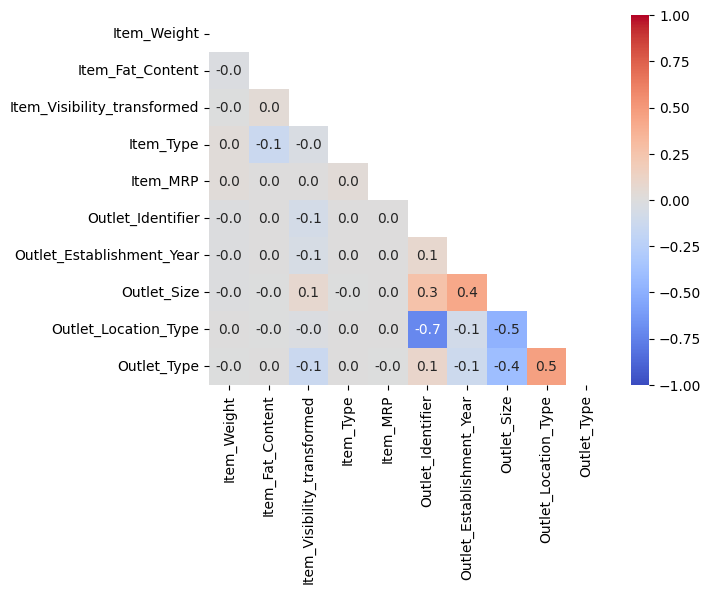

In [46]:
matrix_selected = np.triu(X_selected.corr())
sns.heatmap(X_selected.corr(), annot=True, fmt='.1f', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=matrix_selected)

# TRAINING AND EVALUATION WITH KFOLD 

Number of features: 1, R^2: 0.3089, 0.0257
Number of features: 2, R^2: 0.5795, 0.0246
Number of features: 3, R^2: 0.5598, 0.0256
Number of features: 4, R^2: 0.5545, 0.0214
Number of features: 5, R^2: 0.5405, 0.0208
Number of features: 6, R^2: 0.5396, 0.022
Number of features: 7, R^2: 0.5389, 0.0267
Number of features: 8, R^2: 0.5321, 0.0224
Number of features: 9, R^2: 0.5337, 0.0252
Number of features: 10, R^2: 0.5381, 0.0223


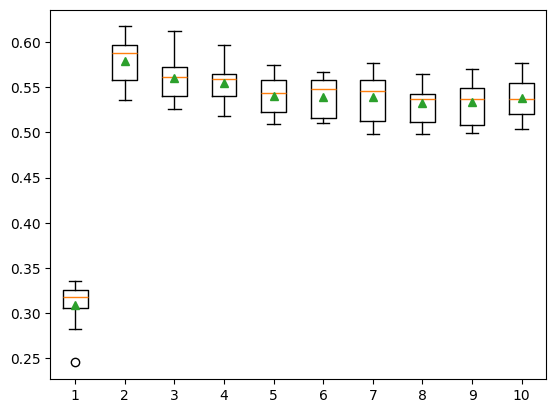

In [54]:
# Perform feature selection for the first dataset
num_features_original = [i+1 for i in range(X_original.shape[1])]
results_original = list()

for k in num_features_original:
    scaler = StandardScaler()
    fs = SelectKBest(score_func=f_regression, k=k)
    model = XGBRegressor()
    pipeline = Pipeline(steps=[('s', scaler), ('anova', fs), ('m', model)])
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_original, y_original, scoring='r2', cv=cv)
    results_original.append(scores)
    print(f"Number of features: {k}, R^2: {round(np.mean(scores),4)}, {round(np.std(scores),4)}")
    
plt.boxplot(results_original, tick_labels=num_features_original, showmeans=True)
plt.show()

Number of features: 1, R^2: 0.3031, 0.0238
Number of features: 2, R^2: 0.6559, 0.0217
Number of features: 3, R^2: 0.6392, 0.0194
Number of features: 4, R^2: 0.6382, 0.0193
Number of features: 5, R^2: 0.6268, 0.0192
Number of features: 6, R^2: 0.6284, 0.0227
Number of features: 7, R^2: 0.6237, 0.0214
Number of features: 8, R^2: 0.6205, 0.0249
Number of features: 9, R^2: 0.6233, 0.0223
Number of features: 10, R^2: 0.6229, 0.021


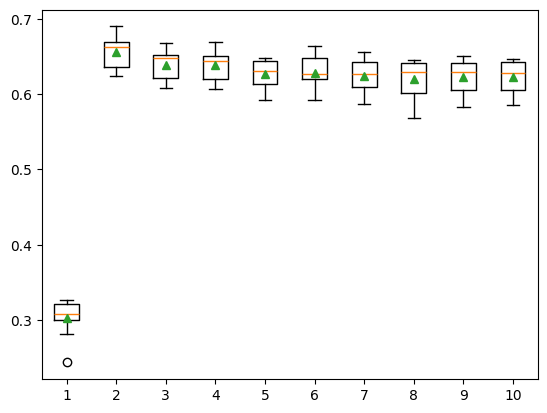

In [55]:
# Perform feature selection for the second dataset
num_features_selected = [i+1 for i in range(X_selected.shape[1])]
results_selected = list()

for k in num_features_selected:
    scaler = StandardScaler()
    fs = SelectKBest(score_func=f_regression, k=k)
    model = XGBRegressor()
    pipeline = Pipeline(steps=[('s', scaler), ('anova', fs), ('m', model)])
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_selected, y_selected, scoring='r2', cv=cv)
    results_selected.append(scores)
    print(f"Number of features: {k}, R^2: {round(np.mean(scores),4)}, {round(np.std(scores),4)}")
    
plt.boxplot(results_selected, tick_labels=num_features_selected, showmeans=True)
plt.show()